Code for sending a sinusoidal signal

In [38]:
from matplotlib import pyplot as plt
import numpy as np
from math import sin, pi
import time
import struct

import alsaaudio as aa

import itertools # Useful library when we have multiple channels

Setting some parameters

In [39]:
pack_format = 'h' # short int with dimension 2 bytes matching the PCM format, this needs to be changed when we change the PCM data format

rate = 100000 # Rate at which we create the samples of the signal
duration = 10 # I think this is only needed to stop the data stream after a certain time
channels = 1 # Since there is one channels each frame consists of one sample

format = aa.PCM_FORMAT_S16_LE # Each sample is 16 bit LittleEndian so each frame is 16 bit which corresponds to a frame_size of 2 bytes

# The data rate in this situation is rate*frame_size=8000*2=16 kBytes/s

Creation of the signal

In [40]:
def generate_sin(frequency, duration, amplitude = 32000):
    '''With this function we want to create a sinusoidal function with frequency 'frequency' and duration 'duration'.'''

    cycle_size = int(rate/frequency) # I think this is the number of samples that are present in a sin() with a certain frequency

    factor =  int(duration*frequency) # How many FULL cycles there are in the duration. I don't know why we would need the ceil() function

    size = cycle_size*factor # Total number of samples in the full signal --> if one channel identical to number of frames we send
    print('The number of frames is %i' % size)
 
    sine = [int(amplitude*sin(2*pi*frequency*i/rate)) for i in range(size)] 

    if channels > 1:
        sine = list(itertools.chain.from_iterable(itertools.repeat(x, channels) for x in sine))

    return struct.pack(str(size*channels) + pack_format, *sine)

In [41]:
class SinePlayer():
    def __init__(self):
        self.device = aa.PCM(channels=channels, format=format, rate=rate, periodsize=160, cardindex=2)

    def change(self, frequency):
        if frequency > (rate/2):
            raise ValueError('Maximum frequency is %d' % (rate/2))

        return generate_sin(frequency, duration)
    
    def run(self, frequency):
        signal = self.change(frequency)
        print('start buffering')
        self.device.write(signal)

        return signal

Now the actual sending of a signal

In [42]:
sine = SinePlayer()

data = sine.run(440) # We store the bytes sent in output
print('samples buffered')

The number of frames is 998800


start buffering
samples buffered


Check if the data we sent make sense

We sent 1997600.000000 many data
[     0    884   1768 ... -30828 -31053 -31255]


(0.0, 1000.0)

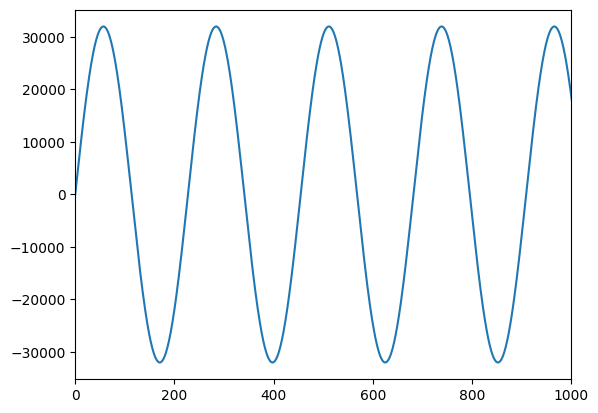

In [43]:
print('We sent %f many data' % len(data))

format = np.frombuffer(data, dtype=np.short) # Reconvert from bytes to int16

print(format)

plt.plot(format)
plt.xlim(0,1000)

We wait for a little bit and then close the device

In [44]:
time.sleep(20)

In [45]:
sine.device.close()